In [3]:
import pandas as pd
products = pd.read_csv("../data/amazon_baby_subset.csv")

In [3]:
import json
with open("important_words.json") as data:
    index = json.load(data)
important_words = [str(x) for x in index]

products = products.fillna({'review':''})  # fill in N/A's in the review column

def remove_punctuation(text):
    import string
    return text.translate(None, string.punctuation)
products['review_clean'] = products['review'].apply(remove_punctuation)
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

In [5]:
with open("module-4-assignment-train-idx.json") as data:
    train_index = json.load(data)
train_data = products.iloc[train_index]
with open("module-4-assignment-validation-idx.json") as data:
    validation_index = json.load(data)
validation_data = products.iloc[validation_index] 

In [6]:
import numpy as np
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    features_frame = dataframe[features]
    feature_matrix = features_frame.as_matrix()
    label_sarray = dataframe[label]
    label_array = label_sarray.as_matrix()
    return(feature_matrix, label_array)

In [7]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment') 

/home/chaitanya/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [8]:
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    # YOUR CODE HERE
    score =  np.dot(feature_matrix,coefficients)
    
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    # YOUR CODE HERE
    predictions = 1/(1 + np.exp(-score))
    
    # return predictions
    return predictions

In [67]:
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant): 
    
    # Compute the dot product of errors and feature
    ## YOUR CODE HERE
    derivative = np.sum(np.dot(errors, feature))

    # add L2 penalty term for any feature that isn't the intercept.
    if not feature_is_constant: 
        ## YOUR CODE HERE
        derivative -= 2*l2_penalty*coefficient
        
    return derivative

In [10]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    
    return lp

In [72]:
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in xrange(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        ## YOUR CODE HERE
        predictions = predict_probability(feature_matrix, coefficients)  
        
        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in xrange(len(coefficients)): # loop over each coefficient
            is_intercept = (j == 0)
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j].
            # Compute the derivative for coefficients[j]. Save it in a variable called derivative
            ## YOUR CODE HERE
            derivative = feature_derivative_with_L2(errors, feature_matrix[:,j], coefficients[j], l2_penalty, is_intercept)  
            
            # add the step size times the derivative to the current coefficient
            ## YOUR CODE HERE
            coefficients[j] += (step_size*derivative)
        
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
            #print 'iteration %*d: log likelihood of observed labels = %.8f' % \
             #   (int(np.ceil(np.log10(max_iter))), itr, lp)
    return coefficients

In [73]:
coefficients_0_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,np.zeros(194), step_size = 5e-6, l2_penalty = 0, max_iter = 501)
coefficients_4_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,np.zeros(194), step_size = 5e-6, l2_penalty = 4, max_iter = 501)
coefficients_10_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,np.zeros(194), step_size = 5e-6, l2_penalty = 10, max_iter = 501)
coefficients_1e2_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,np.zeros(194), step_size = 5e-6, l2_penalty = 1e2, max_iter = 501)
coefficients_1e3_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,np.zeros(194), step_size = 5e-6, l2_penalty = 1e3, max_iter = 501)
coefficients_1e5_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,np.zeros(194), step_size = 5e-6, l2_penalty = 1e5, max_iter = 501)

In [74]:
coefficients = list(coefficients_0_penalty[1:]) # exclude intercept
word_coefficient_tuples = [(word, coefficient) for word, coefficient in zip(important_words, coefficients)]
word_coefficient_tuples = sorted(word_coefficient_tuples, key=lambda x:x[1], reverse=True)
print len(coefficients_0_penalty)
print len(important_words)

table = pd.DataFrame({'word':important_words,'c_0':coefficients_0_penalty[1:],'c_4':coefficients_4_penalty[1:],'c_10':coefficients_10_penalty[1:],'c_1e2':coefficients_1e2_penalty[1:],'c_1e3':coefficients_1e3_penalty[1:],'c_1e5':coefficients_1e5_penalty[1:]})

194
193


In [75]:
positive_list = word_coefficient_tuples[:5]
negative_list = word_coefficient_tuples[-5:]
positive_words = [str(i[0]) for i in positive_list]
negative_words = [str(i[0]) for i in negative_list]
print positive_words,negative_words

['love', 'loves', 'easy', 'perfect', 'great'] ['returned', 'waste', 'return', 'money', 'disappointed']


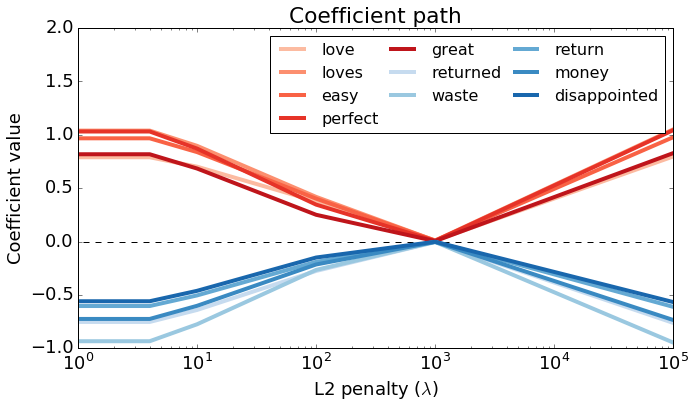

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = table[table['word'].isin(positive_words)]
    table_negative_words = table[table['word'].isin(negative_words)]
    del table_positive_words['word']
    del table_negative_words['word']
    
    for i in xrange(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[i:i+1].as_matrix().flatten(),
                 '-', label=positive_words[i], linewidth=4.0, color=color)
        
    for i in xrange(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[i:i+1].as_matrix().flatten(),
                 '-', label=negative_words[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()


make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])

In [77]:
from __future__ import division
from sklearn.metrics import confusion_matrix
def accuracy_score(feature_matrix,coefficients,data):
    scores = np.dot(feature_matrix,coefficients)
    p = [-1 if i <= 0 else 1 for i in scores]
    k = confusion_matrix(data["sentiment"],p)
    return (k[0][0]+k[1][1])/(k[0][0]+k[0][1]+k[1][0]+k[1][1])
    
print "Accuracy on training data"    
for j in [coefficients_0_penalty,coefficients_4_penalty,coefficients_10_penalty,coefficients_1e2_penalty,coefficients_1e3_penalty,coefficients_1e5_penalty] :
    print accuracy_score(feature_matrix_train,j,train_data)

print ""
print "Accuracy on validation data"
for j in [coefficients_0_penalty,coefficients_4_penalty,coefficients_10_penalty,coefficients_1e2_penalty,coefficients_1e3_penalty,coefficients_1e5_penalty] :
    print accuracy_score(feature_matrix_valid,j,validation_data)

Accuracy on training data
0.785156157787
0.785108944548
0.784990911452
0.783975826822
0.775855149784
0.680366374731

Accuracy on validation data
0.78143964149
0.781533003454
0.781719727383
0.781066193633
0.771356549342
0.667818130893
